# debug why there are inf or very large values in spectra


---

In [1]:
import os, shutil
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.start_workers(20)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.19:35133 Dashboard: http://10.148.1.19:8787/status,Cluster Workers: 38 Cores: 152 Memory: 1900.00 GB


---
# load spectra and identify large values

In [15]:
v = 'SSUV'

D = [xr.open_zarr(scratch+'mit/spectra/%s_f%02d.zarr'%(v,face)) for face in range(13)]
ds = xr.concat(D, dim='face')

grid = xr.open_zarr(scratch+'mit/grid.zarr')
ds = xr.merge([ds,grid])

print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1920, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 -11.96 -11.95 -11.94 ...
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    Depth      (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 96, 96)>
    XC         (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 96, 96)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 96, 96)>
    YC         (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 96, 96)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 96, 96)>
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ..

In [18]:
E = ds.SSUV.sel(face=1, freq_time=2., method='nearest').persist()

In [36]:
# there are no inf values in spectra, it is log10 that introduces them ...
Einf = E.where(xr.ufuncs.isinf(E),drop=True)
print(Einf)
print(Einf.shape)
print(E.isel(i=0,j=0).values)

<xarray.DataArray 'SSUV' (j: 0, i: 0)>
dask.array<shape=(0, 0), dtype=float64, chunksize=(0, 0)>
Coordinates:
    freq_time  float64 2.0
  * i          (i) int64 
  * j          (j) int64 
    face       int64 1
    Depth      (j, i) float32 dask.array<shape=(0, 0), chunksize=(0, 0)>
    XC         (j, i) float32 dask.array<shape=(0, 0), chunksize=(0, 0)>
    YC         (j, i) float32 dask.array<shape=(0, 0), chunksize=(0, 0)>
    rA         (j, i) float32 dask.array<shape=(0, 0), chunksize=(0, 0)>
(0, 0)
0.012768087908625603


(array([7.185070e+06, 7.413887e+06, 0.000000e+00, 2.000000e+00,
        0.000000e+00, 1.000000e+00, 2.000000e+00, 1.000000e+00,
        0.000000e+00, 2.000000e+00]),
 array([-5.50353704, -1.67777269,  2.14799166,  5.97375601,  9.79952036,
        13.62528471, 17.45104906, 21.27681341, 25.10257776, 28.92834211,
        32.75410646]),
 <a list of 10 Patch objects>)

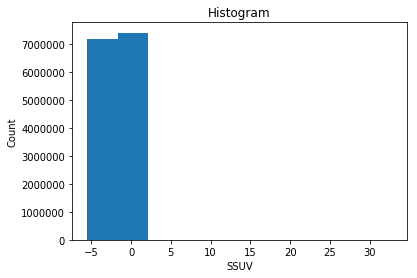

In [42]:
logE = np.log10(E.where(E>0)).persist()
logE.plot.hist()
#logE.fillna(-15.).plot.hist()
#logE.where(xr.ufuncs.isfinite(abs(logE))).fillna(-15.).plot.hist()

(array([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]),
 <a list of 31 Patch objects>)

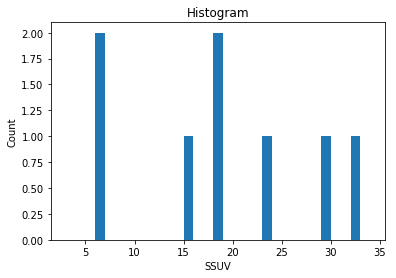

In [40]:
logE.plot.hist(bins=np.arange(3,35,1))

In [41]:
print(E.where(logE>3, drop=True))

<xarray.DataArray 'SSUV' (j: 2, i: 8)>
dask.array<shape=(2, 8), dtype=float64, chunksize=(2, 5)>
Coordinates:
    freq_time  float64 2.0
  * i          (i) int64 1222 1224 1233 1236 1238 2129 2141 2142
  * j          (j) int64 3795 3797
    face       int64 1
    Depth      (j, i) float32 dask.array<shape=(2, 8), chunksize=(2, 5)>
    XC         (j, i) float32 dask.array<shape=(2, 8), chunksize=(2, 5)>
    YC         (j, i) float32 dask.array<shape=(2, 8), chunksize=(2, 5)>
    rA         (j, i) float32 dask.array<shape=(2, 8), chunksize=(2, 5)>


In [43]:
Ebad = E.where(logE>3, drop=True).persist()

In [46]:
print(Ebad.values)

[[           nan            nan            nan            nan
             nan 4.09886225e+06 1.84903412e+06 2.04372548e+18]
 [1.12980095e+15 1.39412258e+29 5.67683750e+32 3.81052195e+23
  1.23131806e+18            nan            nan            nan]]


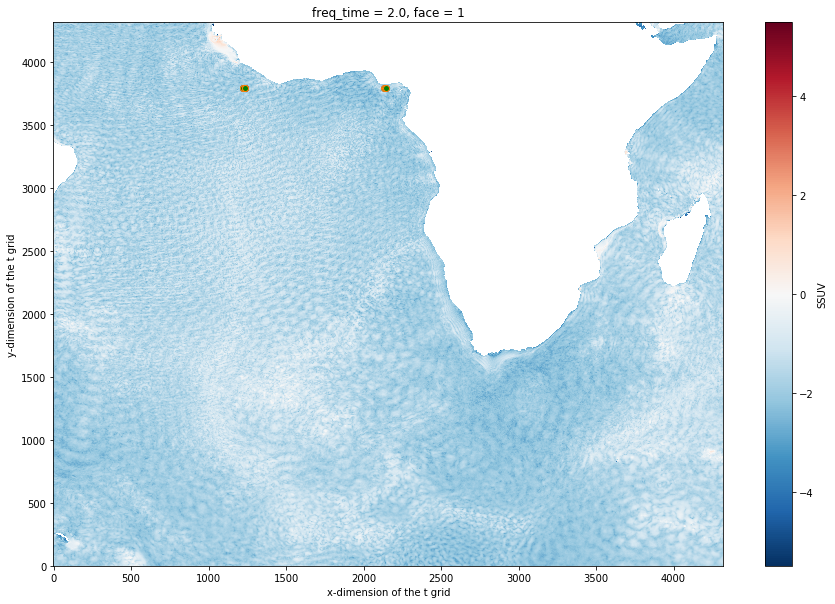

In [54]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
logE.where(logE<3).plot(ax=ax)
ax.plot(Ebad.i+0.*Ebad.j, Ebad.i*0.+Ebad.j, 'o', markerfacecolor='g')

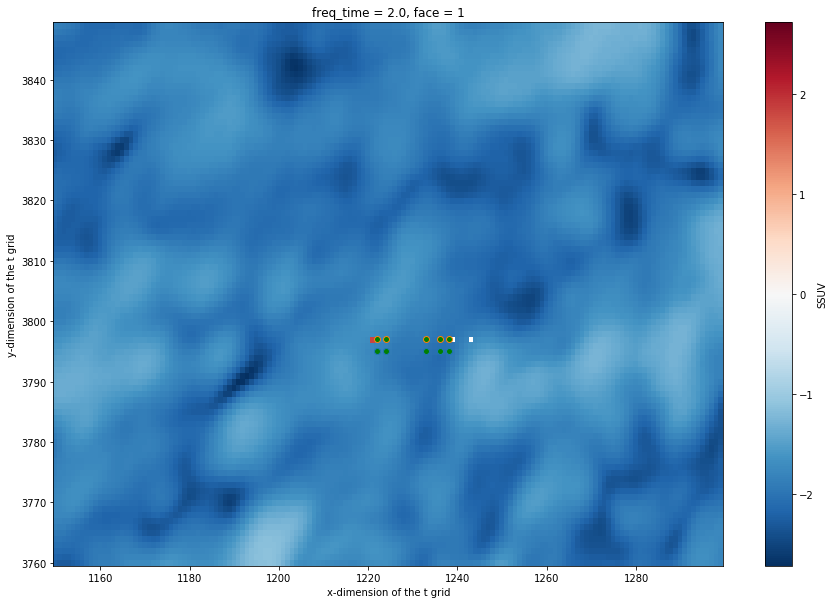

In [57]:
# zoom requires looking up at 
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
#toplt = logE.isel(i=slice(1100,2200), j=slice(3700,3850))
toplt = logE.isel(i=slice(1150,1300), j=slice(3760,3850))
toplt.where(toplt<3).plot(ax=ax)
ax.plot(Ebad.i+0.*Ebad.j, Ebad.i*0.+Ebad.j, 'o', markerfacecolor='g')

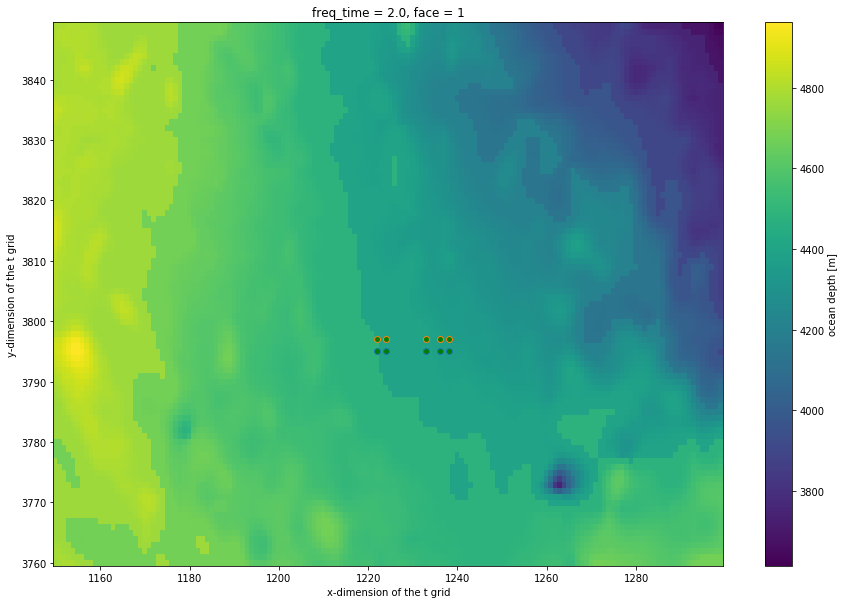

In [59]:
# zoom requires looking up at 
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
#toplt = logE.isel(i=slice(1100,2200), j=slice(3700,3850))
#toplt = logE.isel(i=slice(1150,1300), j=slice(3760,3850))
#toplt.where(toplt<3).plot(ax=ax)
toplt = logE.Depth.isel(i=slice(1150,1300), j=slice(3760,3850))
toplt.plot(ax=ax)
ax.plot(Ebad.i+0.*Ebad.j, Ebad.i*0.+Ebad.j, 'o', markerfacecolor='g')

In [62]:
del E
del logE

--- 

# load time series

- directly from binaries

- from zarr standard layout. First thing done, result: there are some bad values

In [5]:
V = ['SSU', 'SSV']

# faces
#F = range(13)
F = [1]

# parameters for rechunking
Nt = 24*10 # time chunks
#Nc = 96 # x 45 = 4320
#Nc = 48 # x 90 = 4320
Nc = (96, 48)
# other choices: 432, 27 (long scheduling), 288, 864

In [6]:
# try to reintore compression once the computation goes through
# try to delete del statements

overwrite = False

for face in F:
    
    Efile = scratch+'mit/debug/%s_f%02d.zarr'%('SSUV',face)
    
    if not os.path.isdir(Efile) or overwrite:
        
        # binary to zarr (standard layout)
        %time zarr_std(V, client,  F=face, out_dir=scratch+'mit/debug/')

    print('--- face %d done'%face)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


 SSU converted to zarr,  data is 420.8GB 
 SSV converted to zarr,  data is 426.5GB 
CPU times: user 3min 37s, sys: 13 s, total: 3min 50s
Wall time: 10min 35s
--- face 1 done


In [21]:
dsu = xr.open_zarr(scratch+'mit/debug/SSU.zarr')
dsv = xr.open_zarr(scratch+'mit/debug/SSV.zarr')
ds = xr.merge([dsu,dsv], compat='identical')
print(ds)

ibad = [1222, 1224, 1233, 1236, 1238, 2129, 2141, 2142]
jbad = [3795, 3797]
ds = ds.isel(i=ibad, j=jbad).chunk({'time':-1}).persist()

<xarray.Dataset>
Dimensions:  (face: 1, i: 4320, j: 4320, time: 8785)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
  * face     (face) int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
Data variables:
    SSU      (time, face, j, i) float32 dask.array<shape=(8785, 1, 4320, 4320), chunksize=(1, 1, 4320, 4320)>
    SSV      (time, face, j, i) float32 dask.array<shape=(8785, 1, 4320, 4320), chunksize=(1, 1, 4320, 4320)>


In [23]:
print(ds)

<xarray.Dataset>
Dimensions:  (face: 1, i: 8, j: 2, time: 8785)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
  * face     (face) int64 1
  * i        (i) int64 1222 1224 1233 1236 1238 2129 2141 2142
  * j        (j) int64 3795 3797
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
Data variables:
    SSU      (time, face, j, i) float32 dask.array<shape=(8785, 1, 2, 8), chunksize=(8785, 1, 2, 8)>
    SSV      (time, face, j, i) float32 dask.array<shape=(8785, 1, 2, 8), chunksize=(8785, 1, 2, 8)>


i=1222, j=3795, min=-0.458636, max=0.645147
i=1222, j=3797, min=-0.448928, max=12973592576.000000
i=1224, j=3795, min=-0.456890, max=0.645871
i=1224, j=3797, min=-0.469040, max=144115188075855872.000000
i=1233, j=3795, min=-0.399413, max=0.643093
i=1233, j=3797, min=-9196286667416141824.000000, max=0.661924
i=1236, j=3795, min=-0.379712, max=0.640467
i=1236, j=3797, min=-0.395216, max=238260190183424.000000
i=1238, j=3795, min=-0.367517, max=0.658704
i=1238, j=3797, min=-428296404992.000000, max=0.626101
i=2129, j=3795, min=-781459.687500, max=0.606144
i=2129, j=3797, min=-0.359398, max=0.603219
i=2141, j=3795, min=-0.336838, max=524800.000000
i=2141, j=3797, min=-0.376613, max=0.618989
i=2142, j=3795, min=-0.309876, max=551785857024.000000
i=2142, j=3797, min=-0.335118, max=0.649931


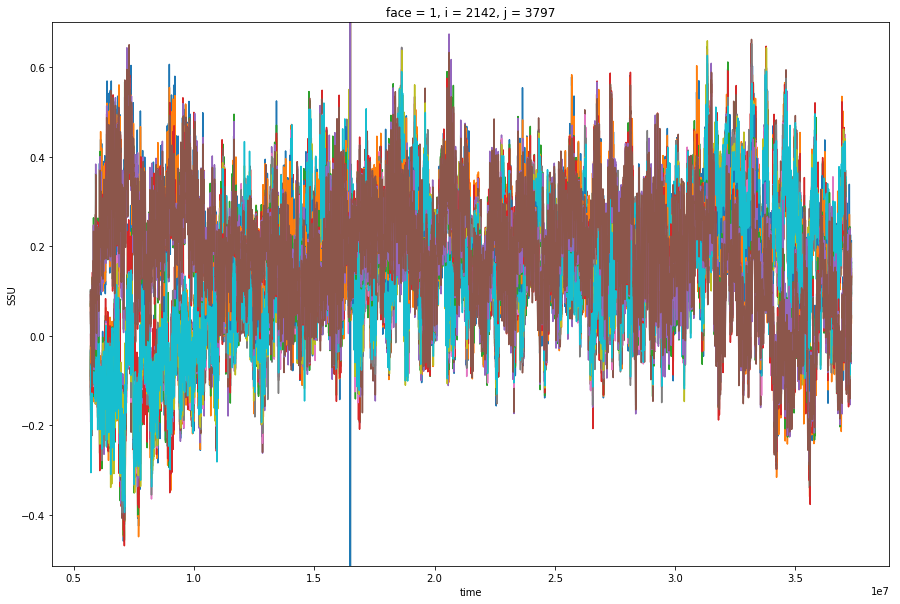

In [29]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
for i in ibad:
    for j in jbad:
        ds.SSU.sel(i=i,j=j).plot(ax=ax)
        print('i=%d, j=%d, min=%f, max=%f'%(i, j, 
                                            ds.SSU.sel(i=i,j=j).min().values, 
                                            ds.SSU.sel(i=i,j=j).max().values))
        #ds.SSV.sel(i=i,j=j).plot(ax=ax)

In [30]:
ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)

In [31]:
f, E = get_E(ds.SSUV)

In [33]:
E.shape

(1920, 1, 2, 8)

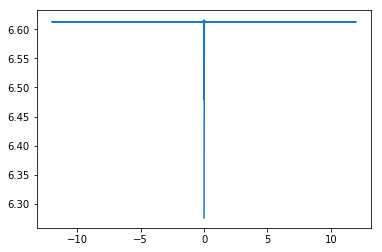

In [38]:
plt.figure()
plt.plot(f, np.log10(E[:,0,0,5]))

In [39]:
del ds

In [43]:
D = []
for v in V:
    #
    data_dir = root_data_dir+v+'/'
    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    #
    p = 'C'
    if v is 'SSU':
        p = 'W'
    elif v is 'SSV':
        p = 'S'
    #
    ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, 
                             time=time, client=client, point=p)
    #
    # should store grid data independantly in a single file
    ds = ds.drop(['XC','YC','Depth','rA'])
    #
    ds = ds.sel(face=F)
    ds = ds.chunk({'face': 1})
    D.append(ds[v])
ds = xr.merge(D, compat='identical')
print(ds)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 1, i: 4320, j: 4320, time: 8785)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    dtime    (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
Data variables:
    SSU      (time, face, j, i) >f4 dask.array<shape=(8785, 1, 4320, 4320), chunksize=(1, 1, 4320, 4320)>
    SSV      (time, face, j, i) >f4 dask.array<shape=(8785, 1, 4320, 4320), chunksize=(1, 1, 4320, 4320)>


In [44]:
# load from raw binaries
ds = ds.isel(i=ibad, j=jbad).chunk({'time':-1}).persist()

i=1222, j=3795, min=-0.458636, max=0.645147
i=1222, j=3797, min=-0.448928, max=12973592576.000000
i=1224, j=3795, min=-0.456890, max=0.645871
i=1224, j=3797, min=-0.469040, max=144115188075855872.000000
i=1233, j=3795, min=-0.399413, max=0.643093
i=1233, j=3797, min=-9196286667416141824.000000, max=0.661924
i=1236, j=3795, min=-0.379712, max=0.640467
i=1236, j=3797, min=-0.395216, max=238260190183424.000000
i=1238, j=3795, min=-0.367517, max=0.658704
i=1238, j=3797, min=-428296404992.000000, max=0.626101
i=2129, j=3795, min=-781459.687500, max=0.606144
i=2129, j=3797, min=-0.359398, max=0.603219
i=2141, j=3795, min=-0.336838, max=524800.000000
i=2141, j=3797, min=-0.376613, max=0.618989
i=2142, j=3795, min=-0.309876, max=551785857024.000000
i=2142, j=3797, min=-0.335118, max=0.649931


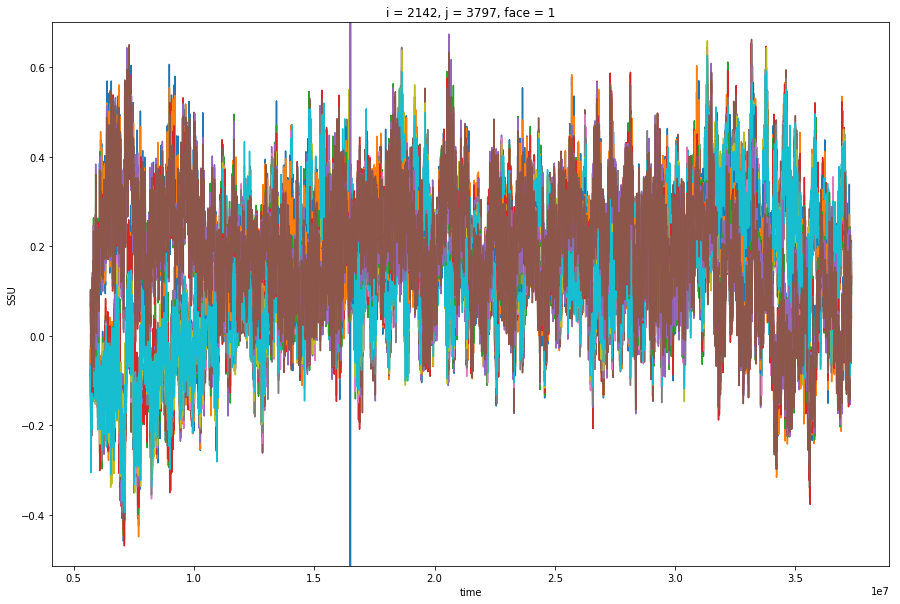

In [46]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
for i in ibad:
    for j in jbad:
        ds.SSU.sel(i=i,j=j).plot(ax=ax)
        print('i=%d, j=%d, min=%f, max=%f'%(i, j, 
                                            ds.SSU.sel(i=i,j=j).min().values, 
                                            ds.SSU.sel(i=i,j=j).max().values))
        #ds.SSV.sel(i=i,j=j).plot(ax=ax)

i=1222, j=3795, min=-0.434995, max=0.511074
i=1222, j=3797, min=-0.419765, max=0.506475
i=1224, j=3795, min=-0.409377, max=0.533711
i=1224, j=3797, min=-0.424576, max=0.520971
i=1233, j=3795, min=-0.392381, max=0.581650
i=1233, j=3797, min=-0.412111, max=0.547656
i=1236, j=3795, min=-0.418307, max=0.515970
i=1236, j=3797, min=-0.402039, max=0.531342
i=1238, j=3795, min=-0.427516, max=0.581370
i=1238, j=3797, min=-0.399764, max=0.515155
i=2129, j=3795, min=-0.420892, max=0.506547
i=2129, j=3797, min=-0.380094, max=0.485161
i=2141, j=3795, min=-0.390005, max=0.602717
i=2141, j=3797, min=-0.381037, max=0.558293
i=2142, j=3795, min=-0.371601, max=0.611325
i=2142, j=3797, min=-0.363794, max=0.545043


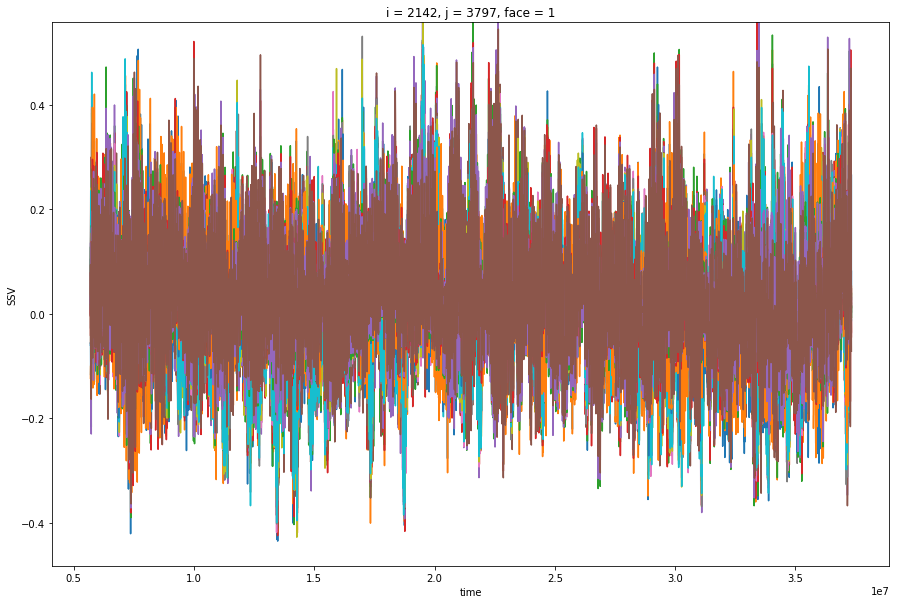

In [54]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
for i in ibad:
    for j in jbad:
        ds.SSV.sel(i=i,j=j).plot(ax=ax)
        print('i=%d, j=%d, min=%f, max=%f'%(i, j, 
                                            ds.SSV.sel(i=i,j=j).min().values, 
                                            ds.SSV.sel(i=i,j=j).max().values))

In [52]:
SSUbad = ds.SSU.where(abs(ds.SSU)>10,drop=True)
print(SSUbad)

<xarray.DataArray 'SSU' (time: 1, face: 1, j: 2, i: 8)>
dask.array<shape=(1, 1, 2, 8), dtype=float32, chunksize=(1, 1, 2, 8)>
Coordinates:
  * i        (i) int64 1222 1224 1233 1236 1238 2129 2141 2142
  * j        (j) int64 3795 3797
  * face     (face) int64 1
  * time     (time) float64 1.65e+07
    dtime    (time) datetime64[ns] dask.array<shape=(1,), chunksize=(1,)>


In [53]:
iters.sel(time=SSUbad.time)

<xarray.DataArray (time: 1)>
array([659952])
Coordinates:
  * time     (time) float64 1.65e+07
    dtime    (time) datetime64[ns] dask.array<shape=(1,), chunksize=(1,)>

In [ ]:
# try to reintore compression once the computation goes through
# try to delete del statements

overwrite = False

for face in F:
    
    Efile = scratch+'mit/debug/%s_f%02d.zarr'%('SSUV',face)
    
    if not os.path.isdir(Efile) or overwrite:
        
        # binary to zarr (standard layout)
        %time zarr_std(V, client,  F=face, out_dir=scratch+'mit/debug/')
        
        if False:
            
            # rechunk all variables
            %time rechunk(V, F=face, Nt=Nt, Nc=Nc, out_dir=scratch+'mit/debug/')
            
            # load data
            dsu = xr.open_zarr(scratch+'mit/rechunked/%s_f%02d.zarr'%('SSU',face))
            dsv = xr.open_zarr(scratch+'mit/rechunked/%s_f%02d.zarr'%('SSV',face))
            ds = xr.merge([dsu,dsv], compat='identical')
            #ds = ds.assign_coords(time_days=ds['time']/86400.)
            
            # try to delete this file writing once the computation goes through
            ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)
            del ds['SSU'], ds['SSV']
            store_zarr(ds, scratch+'mit/spectra/SSUV_tmp.zarr', 
                       encoding={'SSUV': {'compressor': None}})
            print('SSUV stored')
            del ds
            ds = xr.open_zarr(scratch+'mit/spectra/SSUV_tmp.zarr')

            # need to run once to get frequency
            f, E = get_E(ds['SSUV'].isel(i=slice(2),j=slice(2)))
            #
            E = get_E(ds['SSUV'], f=f)

            # store
            E = E.to_dataset()
            # tmp, waiting for xarray release 
            for v in E.variables:
                if hasattr(E[v],'encoding') and 'chunks' in E[v].encoding:
                    del E[v].encoding['chunks']    
            #
            %time E.to_zarr(Efile, mode='w', \
                            encoding={'SSUV': {'compressor': None}})
            del E
        
            # clean up
            for v in V:
                #shutil.rmtree(scratch+'mit/standard/%s.zarr' %v)
                #shutil.rmtree(scratch+'mit/rechunked/%s_f%02d.zarr'%(v,face))
                pass

    print('--- face %d done'%face)

---
# inspect result

In [19]:
face=1
v = 'SSUV'
E = xr.open_zarr(scratch+'mit/spectra/%s_f%02d.zarr'%(v,face))[v].fillna(0.)
E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'SSUV' (j: 4320, i: 4320, freq_time: 1920)>
dask.array<shape=(4320, 4320, 1920), dtype=float64, chunksize=(48, 96, 1920)>
Coordinates:
    face       int64 ...
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 -11.96 -11.95 -11.94 ...
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

 data size: 286.7 GB


In [21]:
print(E.min().values)
print(E.max().values)
# for some reason there are few crazy values, to verify
E = E.where(abs(E)<1e10, other=0.)

0.0
inf


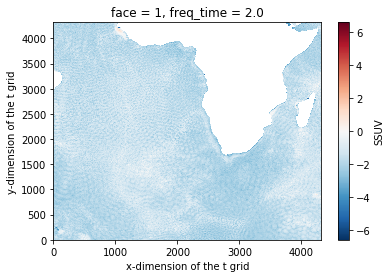

In [22]:
np.log10(E.sel(freq_time=2., method='nearest')).plot()

In [23]:
df = E.freq_time[1]-E.freq_time[0]
E2 = E.where(abs(abs(E.freq_time)-2.)<.2, other=0.).sum(dim='freq_time')*df
E2 = E2.where(E2>0)
print(E2)

<xarray.DataArray (j: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=float64, chunksize=(48, 96)>
Coordinates:
    face     int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


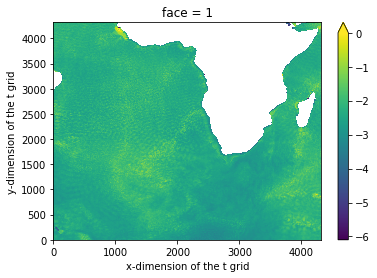

In [24]:
np.log10(E2).plot(vmax=0)

---

In [45]:
w = cluster.start_workers(10)

In [55]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>

In [ ]:
client.restart()